# <center>1017 Project 2: Inventory

<center> Prepared By:  
    
<center> Zhi Xin Zhu (1002117112)
<center>Angela Hsu (1003328874)
<center>Jiayue Xu (1002914162)
<center>Yinjie Yu (1002929913)
<center>Mengyao Wang (1002074970)
    

## Summary

Successfully managing inventory allows companies to meet the demand level of their consumers with an appropriate amount of supply. Ineffective management can result in excess inventory which runs the risk of spoilage, damage or a shift in demand that causes stock to pile up even further. In this report, the team considered the problem with an analyzing Markov Decision Processes (MDP) involved in controlling inventory reordering (replenishment) processes with optimal (s, S) policy, where s represents the reorder level and S represents the order-up-to level, to optimize an inventory system. Firstly, the formulation of the problem as a MDP is proposed with two exogenous information variables: lead time (two weeks) and demand (uniform distribution between 0 and 10). A noticeable action is that the team convert the period from one week to two weeks, and a new probability list is made with basic statistic knowledge. Then the analysis of the system and transition probability matrix are introduced to solve the problem within MDP frame. Next, the team solved the Markov decision process by using two different methods – policy iteration algorithm and Q-learning. These two methods give different answer. For policy iteration, (s, S) is found to be 16 and 49. For Q-learning, the result shows as 23 and 63. Selection of discount factor, γ and learning rate, α contribute to the difference. In this project, these two numbers are randomly selected within a valid range but not tuned. 
 

## MDP Formulation

Markov decision process (MDP) is a widely used technique about probabilistic modelling that helps make decision under uncertainty. These processes could provide evidence of optimal actions should be taken. Any MDP formulation has 5 components (a) Discount factor (b) State (c) Actions (d) Transition probabilities and (e) Reward functions. In this project, a period is set to be 2 weeks, thus instead of using the weekly demand in the project description, the team expands the periodic demand to 0-20. Also, an excel is made for new probability.

### 1. Discount factor
Discount factor γ is assumed to be 0.75

### 2. State space - current inventory level
S = {0, 1, 2, 3, … ,500}

### 3. Actions – order size
A = {0, 1, 2, 3, … ,500}


In [1]:
import numpy as np
import pandas as pd
import time 
import matplotlib.pyplot as plt

# define parameters
price = 10
c = 4
h = 2*(14/365)
k = 100
penalty = 15
df = pd.read_csv("probability.csv")
df

,demand,frequency,probability,ev
0,0,1,0.0083,0.0000
1,1,2,0.0165,0.0165
2,2,3,0.0248,0.0496
3,3,4,0.0331,0.0992
4,4,5,0.0413,0.1653
5,5,6,0.0496,0.2479
6,6,7,0.0579,0.3471
7,7,8,0.0661,0.4628
8,8,9,0.0744,0.5950
9,9,10,0.0826,0.7438


#### Revenue function

In [2]:
# revenue function
def revenue(u):
    if u <=20:
        revenue = price * sum(df["ev"][:u])
    else:
        revenue = price * sum(df["ev"][:])
    return revenue

# revenue(200)

100.0

### 4. Reward function

There are five scenarios to consider in formulating reward functions.
-	**If a > 0 and s < 20**, considered the maximum demand during the lead time is equal to 10*2 = 20, it means the current inventory level may not satisfy the customer’s demands. Then the revenue function should subtract the ordering cost, holding cost, and stockout penalty.
-	**If a > 0 and s > 20**, it means the current inventory quantity is greater than the maximum demand within the lead time, then there is only existing ordering cost and holding cost without stockout penalty.
-	**If a = 0 and 0 < s < 20**, it means the company does not order anything and the current inventory quantity may not satisfy the maximum demand within the lead time, then there exists inventory holding cost, stockout penalty and no ordering cost.
-	**If a = 0 and s >= 20**, the reward function only considers inventory holding cost.
-	**If a = 0 and s = 0**, then the team only considers stockout penalty.


In [3]:
# reward function
def r(s,a):
    stockout = 0 
    u = s + a 
    # exist ordering cost and stockout
    if s+a> 500:
        reward = -1E10
    elif a > 0 and s < 20:                
        for i in range(s+1,20+1):
            stockout += (i-s)*df["probability"][i]
        reward = revenue(u) - (k+c*a) - h*(u) - penalty*(stockout)
    # exist ordering cost and no stockout
    elif a > 0 and s >= 20:
        reward = revenue(u) - (k+c*a) - h*(u)
    # no ordering cost and get inventory cost and stockout    
    elif (a==0 and u > 0) and s < 20:
        for i in range(s+1,20+1):
            stockout += (i-s)*df["probability"][i]
        reward = revenue(u) - h*(u) - penalty*(stockout)
    # no ordering cost and get inventory cost and no stockout    
    elif (a==0 and u > 0) and s >= 20:
        reward = revenue(u) - h*(u)
    # no ordering and no inventory cost
    elif a == 0 and u == 0: 
        for i in range(s+1,20+1):
            stockout += (i-s)*df["probability"][i]
        reward = -penalty*(stockout)
    return reward 

#### Reward matrix

In [4]:
# reward matrix
state_a=[]
for s in range(501):
    for a in range(501):   
        state_a.append(r(s,a))

A = state_a
reward = np.reshape(A, (501, 501))
df_reward=pd.DataFrame(reward)
df_reward

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
0,-150.015000,-2.540917e+02,-2.580034e+02,-2.615841e+02,-2.646688e+02,-2.670926e+02,-2.686903e+02,-2.692960e+02,-2.687447e+02,-2.668714e+02,...,-2.151681e+03,-2.155757e+03,-2.159834e+03,-2.163911e+03,-2.167988e+03,-2.172064e+03,-2.176141e+03,-2.180218e+03,-2.184294e+03,-2.188371e+03
1,-135.214712,-2.391264e+02,-2.427071e+02,-2.457918e+02,-2.482156e+02,-2.498133e+02,-2.504190e+02,-2.498677e+02,-2.479944e+02,-2.446331e+02,...,-2.136880e+03,-2.140957e+03,-2.145034e+03,-2.149111e+03,-2.153187e+03,-2.157264e+03,-2.161341e+03,-2.165417e+03,-2.169494e+03,-1.000000e+10
2,-120.496925,-2.240776e+02,-2.271623e+02,-2.295861e+02,-2.311838e+02,-2.317895e+02,-2.312382e+02,-2.293649e+02,-2.260036e+02,-2.209893e+02,...,-2.122328e+03,-2.126404e+03,-2.130481e+03,-2.134558e+03,-2.138635e+03,-2.142711e+03,-2.146788e+03,-2.150865e+03,-1.000000e+10,-1.000000e+10
3,-105.820137,-2.089048e+02,-2.113286e+02,-2.129263e+02,-2.135320e+02,-2.129807e+02,-2.111074e+02,-2.077461e+02,-2.027318e+02,-1.977175e+02,...,-2.108147e+03,-2.112224e+03,-2.116300e+03,-2.120377e+03,-2.124454e+03,-2.128530e+03,-2.132607e+03,-1.000000e+10,-1.000000e+10,-1.000000e+10
4,-91.143849,-1.935676e+02,-1.951653e+02,-1.957710e+02,-1.952197e+02,-1.933464e+02,-1.899851e+02,-1.849708e+02,-1.799565e+02,-1.751073e+02,...,-2.094463e+03,-2.098539e+03,-2.102616e+03,-2.106693e+03,-2.110769e+03,-2.114846e+03,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,61.950685,-4.212603e+01,-4.620274e+01,-5.027945e+01,-5.435616e+01,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,...,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10
497,61.873973,-4.220274e+01,-4.627945e+01,-5.035616e+01,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,...,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10
498,61.797260,-4.227945e+01,-4.635616e+01,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,...,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10
499,61.720548,-4.235616e+01,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,...,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10,-1.000000e+10


In [5]:
reward = df_reward.to_numpy()

### 5. Transition probabilities
There are four scenarios to consider in formulating transition probability.
-	If the current inventory level, inventory level of the previous state and the order size are 0, then the probability is definitely equal to 1
-	It's impossible to appear the following situations:
    * the current inventory level is greater than the sum of inventory level of the previous state and the order size.
    * the sum of inventory level of the previous state and the order size subtract 20 is greater than the current inventory level.
-	If the inventory level of the previous state plus the order size is smaller than 20 while the current inventory level is 0, the probability is the sum of all probability of demand from the previous inventory level to 20.
-	The last situation is the normal one. The demand level is the difference between the previous state plus order size and current state, so the transition probability in this case is the probability of that specific demand.


In [6]:
# transition probability
def p(previous,now,a):
    if now == previous == a == 0:
        p = 1
    elif now > previous+a or previous+a-20 > now:   # impossible scenario
        p = 0
    elif previous+a < 20 and now == 0:
        p = sum(df["probability"][previous+a:])
    else:
        demand = (previous+a) - now 
        p = df["probability"][demand]
    return p

# p(197,200,3)

#### Reshape transition probabilities function to 3D array

In [7]:
# transition matrix
nx = 501
ny = 501
nz = 501
prob = np.empty((nx,ny,nz))
for k in range(nz):
    for j in range(ny):
        for i in range(nx):
            prob[i,j,k] = p(i,j,k)

## Policy Iteration

## Method

Policy Iteration is a fundamental algorithm that helps learn the optimal policy in ‘Reinforcement Learning’. In other words, it maximizes the long-term discounted reward. This technique is always useful when there are multiple options to choose from, and each option has its own rewards and risks [1]. In this section, the detailed explanation about how to apply the ‘Policy Iteration’ algorithm to solve the Markov decision process will be illustrated.

In general, policy iteration often consists of two simulation and interactive processes. The first one is policy evaluation which evaluates the policy through a specific calculation function, so that the value function can be consistent with the current strategy. The other one is strategy improvement, based on the value obtained before, a better policy should be invented, which is inconsistent with the current value function. To apply policy iterations, the following requirement should be satisfied: the value used for ‘state’ and ‘action’ are all discrete values.

In this project, a value of policy is first considered to be set as 0, while it is found that the V π (s) cannot be figured out. As a result, the team initialized the π as 1 and followed the Bellman’s equation below for V π (s) [1]:

 <img src="policy 1.png" width=600>
 
Up to now, a value is obtained and then a process extraction process is applied, which convert the value into a policy and is done by taking the policy that maximizes over expected values and this is the policy improvement process [2].

 <img src="policy 2.png" width=600>
 
If the best action is better than the present policy action, the current action will be replaced by the best action and the above steps will be iterated until convergence. If the policy did not change throughout an iteration, then then team can consider that the algorithm has converged. As a result, optimal value of s and a can be obtained.

Policy iteration is always compared with value iteration which is an alternative method to find optimal values. One of the major differences in these two is that in policy iteration, the policy always changes every iteration, however, in value iteration, though the value function changes every iteration, the optimal policy related stays the same for several successive iterations. As a result, policy iteration usually takes far few steps. In terms of time requirement, actually, it takes longer for policy iteration to complete each individual iteration because the linear equation have to be solved. Gaussian elimination is introduced and is in O〖(N〗^3). In contrast, algorithms in value iteration takes O(NML) which take less time. However, as mentioned previously, policy iteration takes fewer steps in total [3]. Therefore, it is still considered as the better algorithm in practice.

There are also some limitations, the convergence effect of the policy iteration largely depends on the value function. This data and table-based algorithm and may not achieve satisfactory effect when facing with some problem in real applications. In addition, when facing high dimensional problems, it may lead to curse of dimensionality [4].


## Explanation of major functions in the code 

There are two major steps in policy iteration, initialization, and policy improvement. 

**First step:** The policy iteration needs to first initialize π(s) to initialize V^((π) ) (s). The initial policy is set to be 0 for all given states arbitrarily. The corresponding system of linear equation is calculated by finding the inverse of the summation of V^((π) ) (s) for all 501 states. Given known r(s,a), the equation to solve becomes:

 <img src="policy 3.png" width=600>

**Second step:** Then, policy improvement is required to maximize V^((π) ) (s) by selecting different policy. With input s0, action, and V^((π) ) (s), “max_pi” function returns the index of action that maximize. π(s0). For each iteration, a new policy is generated, and the new one is compared to the previous one using the “check_pi” function, which checks whether the new policy equals to the old one and returns Boolean type output. Only if all the actions in new policy is equal to previous one that the iteration stops, and the optimal policy is determined.


In [8]:
def check_pi(old_pi, new_pi):
    return (new_pi == old_pi)

In [9]:
def max_pi(s0, max_act, X, r):
    B = [r[s0, act] + gamma * sum([prob[s0,s1,act]*X[s1] for s1 in range(501)]) for act in range(max_act)]
    max_q = max(B)
    max_a = B.index(max_q)
    return max_a

In [10]:
states = list(range(0,501))
actions = list(range(0,501))
N_STATES = len(states)
N_ACTIONS = len(actions)
max_action_s = np.arange(1,502)
max_action_s = np.sort(max_action_s)[::-1]
gamma = 0.75
new_policy = np.zeros(N_STATES)
# initialize policy and value arbitrarily
policy = [0 for s in range(N_STATES)]
new_equal_old = np.zeros(N_STATES, dtype=bool)
# is_value_changed = True
iterations = 0
start = time.time()
iteration = 0 
runtime = 0 
while sum(new_equal_old) < 501:
    start = time.time()
    iterations += 1
    print('Iteration ',iterations)
    ### calculate V 
    V_mat = np.zeros((N_STATES, N_STATES))     # matrix to store the system of linear eqns for V 
    rsa = np.zeros(N_STATES)
    for s in range(N_STATES):
        #calculate V[s] given policy 
        rsa[s] = reward[s,policy[s]]
        V_mat[s] = -gamma * prob[s,:,policy[s]]
        V_mat[s,s]+=1
    V_pi_s = np.linalg.inv(V_mat).dot(rsa)

    new_policy = np.zeros(N_STATES)
    for s in range(N_STATES):
        new_policy[s] = max_pi(s,max_action_s[s],V_pi_s, reward)
        new_equal_old[s] = check_pi(policy[s],new_policy[s])
    policy = new_policy
    policy = policy.astype(int)
    runtime += time.time()-start
    if runtime > 1800:
        break 
# print(time.time()- start)
print('optimal policy:')
print(policy)

Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
optimal policy:
[49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [11]:
optimal_pol_pi = pd.DataFrame()
optimal_pol_pi['opt_a_s'] = policy
optimal_pol_pi['V_s'] = V_pi_s
optimal_pol_pi.head(40)

,opt_a_s,V_s
0,49,-206.595642
1,48,-187.718642
2,47,-169.089142
3,46,-150.831642
4,45,-133.070642
5,44,-115.929142
6,43,-99.531642
7,42,-84.002642
8,41,-69.465142
9,40,-56.043642



### Explanation of the solutions found 

The optimal (s, S) policy computed by the policy iteration method is (16,49). The solution is determined by choosing the state (with non-zero optimal action) with the maximal V^((π) ) (s). The optimal minimum inventory level s for our MDP problem is state 16 and the optimal maximum inventory level S is state 16 plus the corresponding optimal action of 33. 

Any state with zero action is not considered even though it may have a better V-value because this means the minimum inventory level equals to the maximum inventory level. This is not a feasible solution since such policy suggest that we do not order. States with optimal action equal to zero may have a higher V-value due to the structure of the reward function. When we have an inventory level that is higher than the maximum bi-weekly demand, we can satisfy the demand without any replenishment, thus the reward for such state will only have revenue and holding (no stockout penalty and order cost). Therefore, the reward is higher than state with non-zero action. 



In [12]:
subset = optimal_pol_pi[optimal_pol_pi.opt_a_s !=0]
subset = subset.reset_index()
subset['V_s'] = pd.to_numeric(subset['V_s'])
optimal_s_pi = subset.iloc[subset['V_s'].argmax(),0]
optimal_S_pi = subset.iloc[subset['V_s'].argmax(),1]+optimal_s_pi
print('The optimal (s,S) policy found with policy iteration algorithm is : ({},{})'.format(optimal_s_pi, optimal_S_pi))

The optimal (s,S) policy found with policy iteration algorithm is : (16,49)


## Q-Learning

## Method

Q-learning is known as model-free reinforcement learning algorithm. The term of ‘model-free’ refers to problem solving technics with stochastic transitions and rewards, while no adaptions is essential. Therefore, it can be utilized to evaluate an optimal action-selection policy for any given finite MDP. The principle is related to discover an optimal policy through maximizing the expected value of the reward function via successive iteration. For any finite MDP, Q-learning would be able to identify an optimal action selection policy according to given infinite exploration time and a partly random policy [5]. The nomenclature of ‘Q’ indicates that the corresponding function applied algorithm to compute the expected rewards for an action taken in a given state [6]. This algorithm is widely applied in the realms of robotics and games. For further study, it can also be employed in much more complex feature spaces with neural networks consisting of a large table including all the state-action combinations [7]. 

According to the Bellman equation exhibited below, it is accessible to evaluate the maximum future reward, which is defined as the reward would be received once stepping into the current state s plus the maximum future reward for the next state s'.

 <img src="Q 1.png" width=300>
 
Once cooperating the Bellman equation to iterate new Q values, the corresponding equation is expressed as:

 <img src="Q 2.png" width="600">
 
where α is the learning rate which is able to control how much the difference is feasible between the previous and new Q values. In this project, α is defined as 0.5. 

The general principle of Q-learning applies initialization guess of Q(s,a), where can be set as 0 or randomly chosen for all Q values at all states s and actions a, followed by constructing a tabulated Q matrix to include every state and action pair. Then, with an initial state, determination of action can be achieved based on policy derived from Q (e.g., ε-greedy). As specification, epsilon decay is introduced, with rate defined as 0.005. Thus, while promoting iteration, ε would decrease from original set value of 0.9, and consequential the value of 1-εwould surge. As a result, the ε-greedy action turns be effective. Once action is implemented, further observation on reward and new state can be done. Owning to the derived equation, respective Q values can be updated on the matrix until the next state approaches terminal. In other words, iteration is finalized once convergence of π^* or Q is reached. In comparison with policy iteration algorithm, transient states between previous and current states are not taken in consideration. Meanwhile, Q learning tends to be an off-policy learning, as it takes in account of action values for all paired action with given states, followed by selecting the maximum action value pair [8].

One of obvious benefits of Q learning refers to the model-free principle, where it is viable to perform comparison among all expected utility of the available action without introducing a model of the environment [9]. Therefore, for cases that the environment is significantly large or not able to be shortly describe, Q learning algorithm could be an optimum option. As this category of enforcement learning is similar to the learning progress of human beings, it is expected to approach perfection, once compared with other supervised, unsupervised, and semi-supervised machine learning algorithm [10]. 

However, the common drawback is related to time-consuming procedures to access the optimal Q value as well as considerable iteration stages to evaluate the rewards. Thus, this algorithm could be a pricy option if assigned budget is limited [9]. 

## Explanation of major functions in the code

The basic logic of the Q-learning implementation is as followed:
1.	Initialize Q-table, size of N_STATES x N_ACTIONS, as all zeros. 
2.	 Repeat for each episode:
    1.	Initialize current state S = 0 and cumulative reward = 0 
    2.	Repeat for each step of episode:
        1.	Select action for current state using the eps_action() function, decay epsilon. 
        2.	Observe the next state using the next_state() function based on the selected action. Observe reward 
        3.	Update Q[current state, action] using xxx 
        4.	Current state = next state 
        5.	Cumulative reward += reward 
    3.	Compute rollout 30-episode average reward 


#### The input for the epsilon greedy function **eps_action(s, q_sa,eps):** is: 
* s: current state 
* q_sa: Q-table 
* eps: epsilon

This function will randomly choose an action with a probability of eps and greedily choose an action with the highest Q (s, a) with probability 1-eps. The epsilon will slowly decay as the algorithm runs through numerous episodes because in the beginning the Q-table is initialized arbitrarily, choosing an action based on Q is meaningless.  However, as the Q-table is updated iteratively, the Q-values are learned, and it is reasonable now that we are more likely to greedily pick an action based on the Q-table. 



#### The input for **next_state(transprob)** is:
* transprob: transition probability p(S’|S+A) for all S’= 0, 1, ...500

This function will return the next state based on the transition probability given the current state and action. Intuitively, this function is a property of the environment. We do not control which next state we land in; we simply sample from the transition probability. 

#### The average reward is used to visualize if the algorithm converges. 



In [13]:
### combined transition probability p(S'| S+a)
combined_prob = np.zeros((N_STATES, N_ACTIONS))
d_prob = df['frequency']/121
combined_prob[0,0] = 1
for i in range(1,20):
    sum_p = []
    sum_p.append(sum(d_prob[i:21]))
    single_p = d_prob[0:i]
    single_p = single_p.tolist()
    single_p.reverse()
    sum_p.extend(single_p)    
    combined_prob[i, 0:i+1] = sum_p
    
for i in range(20,501):
    combined_prob[i, i-20:i+1] = d_prob


In [14]:
### define parameters 
alpha = 0.5   #learning rate 
gamma = 0.75
epsilon = 0.9
epsilon_decay = 0.005
epsilon_final = 0.01

 
N_episodes = 10000
N_steps = 200

In [15]:
### function that determines action based on e-greedy algorithm 
### function will randomly choose available action with probability of epsilon 
### function will choose greedy action with probability 1-epsilon 

def eps_action(s,q_sa,eps):   #(current state, Q(current_state, all action), epsilon
    selection = np.random.choice((0,1), p =[eps, 1-eps])
    available_action = 501 - s
    if selection ==1:
        act = np.argmax(q_sa[0:available_action])
    else:
        act = np.random.choice(np.arange(0,available_action))
    return act

### nextstate function which determines the nextstate based on the transition prob of given action and current state
def nextstate(transprob):
    return np.random.choice(np.arange(0, N_STATES), p = transprob * (1/transprob.sum()))
        
                                 

In [16]:
cum_rewards = []
avg_rewards = []
avg_size = 30

In [17]:
Q = np.zeros([N_STATES,N_ACTIONS])     #initialize Q table
##### impossible action given state will have very negative expected reward
for i in range(N_STATES):
    for j in range(N_ACTIONS):
        if i+j >500:
            Q[i,j] = -1E7

for i in range(N_episodes):
    start = time.time()
    state = 0      #initialize state
    cum_reward = 0
    for j in range(N_steps): 
        action = eps_action(state, Q[state,:], epsilon)   #choose action based on eps greedy
        if epsilon > epsilon_final: ## decay epsilon 
            epsilon *=(1-epsilon_decay)
            
        u = state + action    
        t_prob = combined_prob[u]
        new_state = nextstate(t_prob)        #define next state based on current state and action
        cur_r = reward[state,action]
        cum_reward += cur_r
        Q[state,action] = Q[state,action] + alpha * (cur_r + gamma* max(Q[new_state])-Q[state,action])
        state = new_state
    cum_rewards.append(cum_reward)
    if i < avg_size:
        avg_reward = np.sum(cum_rewards[0:i]) / (i+1)
    else: 
        avg_reward = np.sum(cum_rewards[i-avg_size:i]) / avg_size
    avg_rewards.append(avg_reward)
        
#     print('Episode {} took {}'.format(i,time.time()- start))   

In [18]:
optimal_pol_ql = []
optimal_q = []
for i in range(N_STATES):
    optimal_q.append(Q[i,np.argmax(Q[i])]) 
    optimal_pol_ql.append(np.argmax(Q[i]))


In [19]:
optimal_pol_ql_df = pd.DataFrame()
optimal_pol_ql_df['opt_a_s'] = optimal_pol_ql
optimal_pol_ql_df['Q_SA'] = optimal_q
optimal_pol_ql_df.head(30)

,opt_a_s,Q_SA
0,38,-230.502018
1,456,0.000000
2,61,-185.066591
3,40,-166.162713
4,54,-136.730690
5,58,-146.494146
6,45,-98.625652
7,55,-78.574411
8,51,-73.248713
9,60,-71.533623


## Explanation and visualization of the solutions found
For Q learning algorithm, the optimal (s, S) policy is (23, 63). The optimal solution is determined similarly to the policy iteration algorithm, except we choose the optimal state based on the maximal Q_pi(s).  

To visualize the convergence of the Q-learning algorithm, the average reward for each episode is plotted [Figure 1]. 

From Figure 1, it can be observed that the algorithm starting to converge after 800 iterations. The average reward stabilizes at around 6250. As specification, episode reward would tend to converge at significant episode number. The average reward value diverges between -4000 to 6250 in the first 800 iterations. Once the algorithm reached around 800 iterations, the average reward value converges. 

Obviously, two enforcement learning algorithm employ separate technics, thus the optimum policies generated are not consistent. Except the characteristics included in the Methods session, another difference is related to transition probability. This concept is well introduced in the policy iteration algorithm for the purpose of updating policies with better performance, where transient states all taken in consideration. However, transition probability is not directly applied in Q learning algorithm, as only current state and previous state are essential for performing iteration. 

In [20]:
subset = optimal_pol_ql_df[optimal_pol_ql_df.opt_a_s !=0]
subset = subset.reset_index()
optimal_s_ql = subset.iloc[subset['Q_SA'].argmax(),0]
optimal_S_ql = subset.iloc[subset['Q_SA'].argmax(),1]+optimal_s_ql
print('The optimal (s,S) policy found with policy iteration algorithm is : ({},{})'.format(optimal_s_ql, optimal_S_ql))

The optimal (s,S) policy found with policy iteration algorithm is : (20,54)


### Visualize Episode Reward for Q-Learning Agent

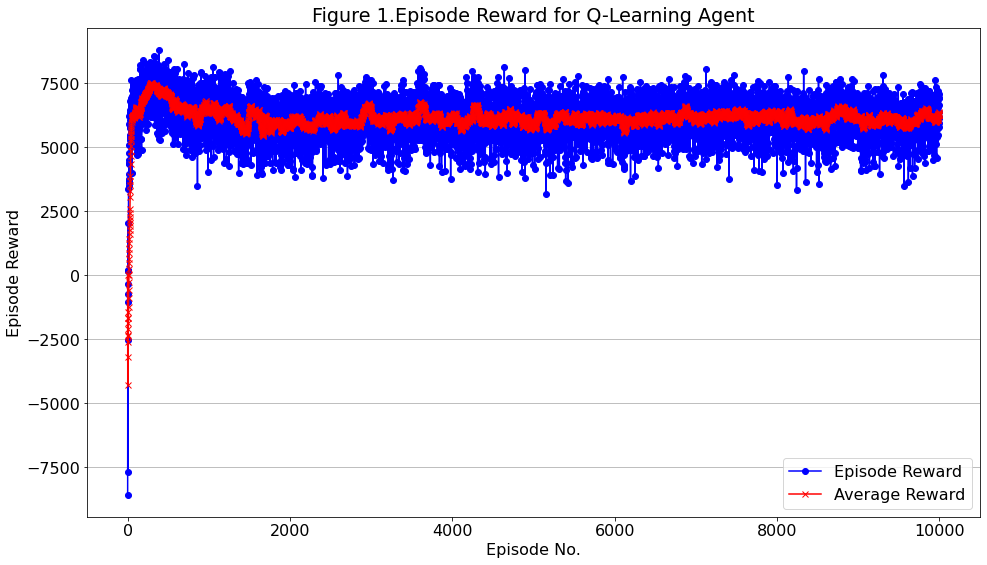

In [23]:
plt.figure(figsize=(16,9))
plt.rc('font', size=16) 
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

plt.title("Figure 1.Episode Reward for Q-Learning Agent")
#plt.bar(np.arange(len(rewards)), rewards, alpha=0.6, color='green', width=5)
plt.plot(np.arange(len(cum_rewards)), cum_rewards, 'o-b')
plt.plot(np.arange(len(avg_rewards)), avg_rewards, 'x-r')
plt.grid(axis='y')
plt.xlabel('Episode No.')
plt.ylabel('Episode Reward')
plt.legend(['Episode Reward', 'Average Reward'])
plt.show()


## Lessons learned 
This project not only guided the team on how to use policy iteration to solve the MDP problem but also introduced the team a simple value-based reinforcement learning – Q-learning. Comparing these two methods, the team found that policy learning incrementally looks at the current values and extracts a policy. Because the action space is finite, the hope is that it can coverage faster. There are two steps to Policy iteration. The first one is policy extraction, which is how we go from a value to a policy by taking the policy that maximizes over expected values. The second step is policy evaluation, which takes a policy and runs value iteration conditioned on a policy. The policy iteration is guaranteed to converge for most reasonable MDPs due to the underlying Bellman Update. For Q-learning, the problem which knowing optimal value is that it is hard to distill a policy from it. The argmax operator is distinctly nonlinear and difficult to optimize over.


## Reference

1.	Bhandarkar, R. Policy Iteration in RL: A step by step Illustration. 2020; Available from: https://towardsdatascience.com/policy-iteration-in-rl-an-illustration-6d58bdcb87a7.
2.	Supavish, P. Policy Iteration — Easy Example. 2019; Available from: https://medium.com/@pesupavish/policy-iteration-easy-example-d3fd1eb98c6c.
3.	Adams, R.P., Planning via Policy Iteration. 2018.
4.	Rust, J.P., A Comparison of Policy Iteration Methods for Solving Continuous-State, Infinite-Horizon Markovian Decision Problems Using Random, Quasi-Random, and Deterministic Discretizations. 1997.
5.	Melo, F.S., Convergence of Q-learning: a simple proof.
6.	Matiisen, T. DEMYSTIFYING DEEP REINFORCEMENT LEARNING. 2015; Available from: https://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/.
7.	Lambert, N. Fundamental Iterative Methods of Reinforcement Learning. 2020; Available from: https://towardsdatascience.com/fundamental-iterative-methods-of-reinforcement-learning-df8ff078652a.
8.	Vinit. Sarsa vs Q-learning. Learn Robotics 2018; Available from: https://vinitsarode.weebly.com/blogs/sarsa-vs-q-learning.
9.	Manju, M.S. An Analysis of Q-Learning Algorithms with Strategies of Reward Function. 2011.
10.	Advantages and Disadvantages of different types of machine learning algorithms. 2020; Available from: https://www.asquero.com/article/advantages-and-disadvantages-of-different-types-of-machine-learning-algorithms/.



